In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [91]:
# Define dataset class
class ECGDataset(Dataset):
    def __init__(self, file_path):
        data = pd.read_csv(file_path, header=None)
        self.signals = torch.tensor(data.iloc[:, :-1].values, dtype=torch.float32)
        self.labels = torch.tensor(data.iloc[:, -1].values, dtype=torch.long)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]  # Remove unnecessary unsqueeze

# Load datasets

def get_dataloader(file_path, batch_size=32):
    dataset = ECGDataset(file_path)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = get_dataloader(r"mitbih_train.csv")
test_loader = get_dataloader(r"mitbih_test.csv")
abnormal_loader = get_dataloader(r"ptbdb_abnormal.csv")
normal_loader = get_dataloader(r"ptbdb_normal.csv")

# Define class labels
class_labels = {0: "Normal", 1: "Supraventricular", 2: "Ventricular", 3: "Fusion", 4: "Unknown"}

In [92]:
# Define Liquid Neural Network model
class LiquidECGClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidECGClassifier, self).__init__()
        self.liquid_layer = nn.RNN(input_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1, input_size)  # Ensure correct shape (batch, seq_len, input_size)
        x, _ = self.liquid_layer(x)
        x = self.fc(x[:, -1, :])  # Take last output for classification
        return x

# Model setup
input_size = 187  # Assuming ECG signals have 187 features
hidden_size = 512
output_size = len(set(pd.read_csv(r"mitbih_train.csv", header=None).iloc[:, -1]))  # Dynamically determine number of classes

model = LiquidECGClassifier(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [93]:
def visualize_data(train_loader):
    samples = {label: None for label in class_labels.keys()}  # Store one sample per class
    
    for signals, labels in train_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if samples[label] is None:
                samples[label] = signals[i].numpy()
            if all(sample is not None for sample in samples.values()):  # Stop when all classes are represented
                break
        if all(sample is not None for sample in samples.values()):
            break
    
    plt.figure(figsize=(10, 6))
    for label, signal in samples.items():
        plt.plot(signal, label=f"Class {class_labels[label]}")
    plt.xlabel("Time Steps")
    plt.ylabel("ECG Signal Value")
    plt.title("Sample ECG Signals from Training Set")
    plt.legend()
    plt.show()

In [94]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for signals, labels in train_loader:
            signals = signals.view(signals.size(0), -1, input_size)
            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    visualize_data(train_loader)
    # Plot training loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid()
    plt.show()

In [95]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for signals, labels in test_loader:
            signals = signals.view(signals.size(0), -1, input_size)
            outputs = model(signals)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(output_size), yticklabels=range(output_size))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1/10, Loss: 0.2913
Epoch 2/10, Loss: 0.1982
Epoch 3/10, Loss: 0.1691
Epoch 4/10, Loss: 0.1516
Epoch 5/10, Loss: 0.1374
Epoch 6/10, Loss: 0.1263
Epoch 7/10, Loss: 0.1177
Epoch 8/10, Loss: 0.1097
Epoch 9/10, Loss: 0.1044
Epoch 10/10, Loss: 0.0987


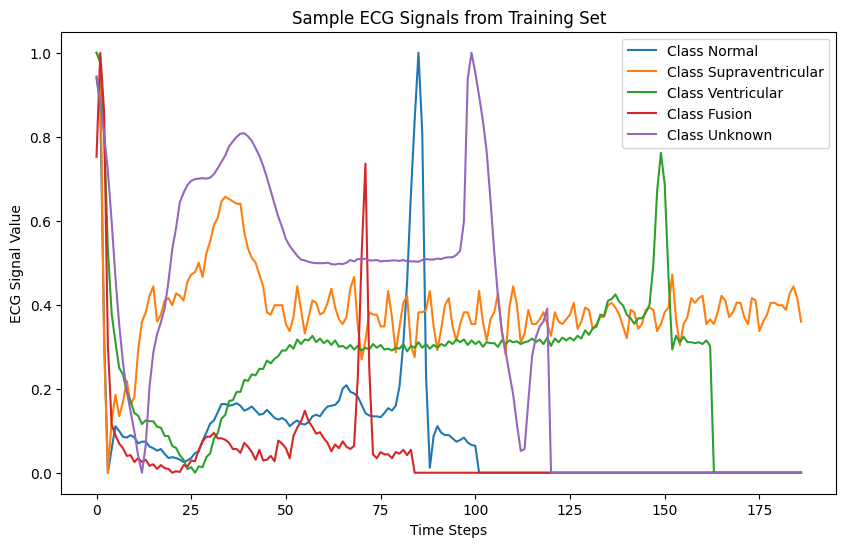

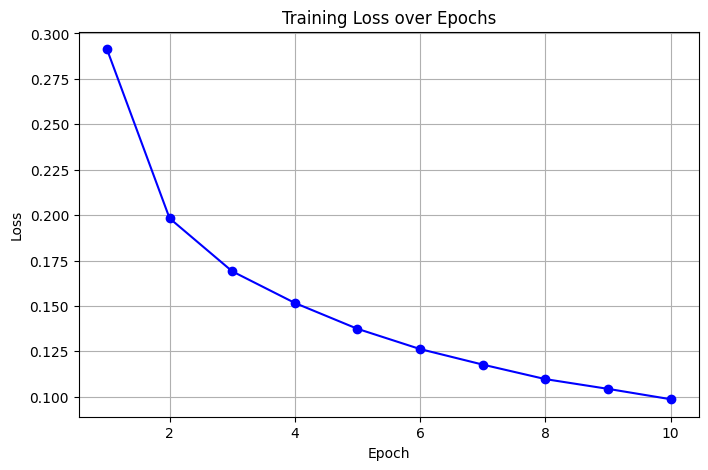

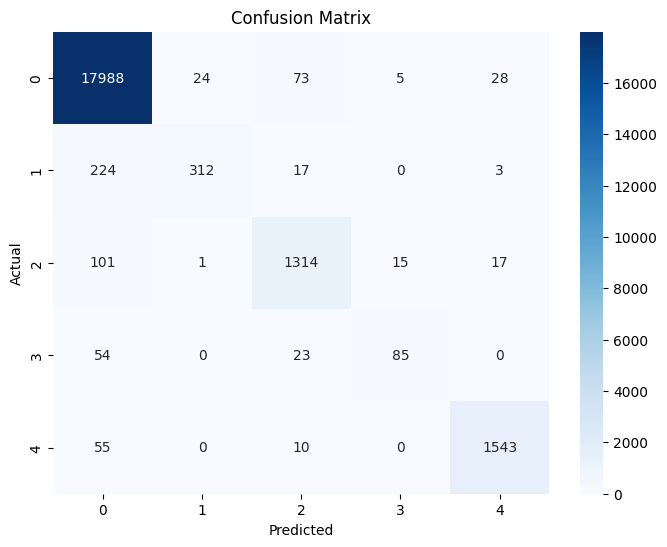

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18118
           1       0.93      0.56      0.70       556
           2       0.91      0.91      0.91      1448
           3       0.81      0.52      0.64       162
           4       0.97      0.96      0.96      1608

    accuracy                           0.97     21892
   macro avg       0.92      0.79      0.84     21892
weighted avg       0.97      0.97      0.97     21892

Test Accuracy: 97.03%


In [96]:
train_model(model, train_loader, criterion, optimizer)
evaluate_model(model, test_loader)

In [ ]:
torch.save(model.state_dict(), "ecg_model.pt")